# MACE in Practice I

In this tutorial, you will learn how to fit and test a `MACE` model (Message Passing Neural Network), which is a highly accurate and efficient MLIP (Machine Learnt Interatomic Potential). The training/testing techniques we show here, however, are broadly applicable to all MLIPs. You can independently learn about MACE by studying the [original method paper](https://proceedings.neurips.cc/paper_files/paper/2022/file/4a36c3c51af11ed9f34615b81edb5bbc-Paper-Conference.pdf). MACE was developed by unifying the Atomic Cluster Expansion (ACE) approach with the Neural Equivariant Interatomic Potentials (NequIP). The mathematical formalism which unifies these methods is explained in the [accompaning paper](https://doi.org/10.48550/arXiv.2205.06643). Another [useful reference](https://doi.org/10.48550/arXiv.2305.14247) showcases the method's performance on published benchmark datasets. The [code implementation](https://github.com/ACEsuit/mace) is publically available and [here](https://mace-docs.readthedocs.io/en/latest/) you can find the documentation.

## Learning Objectives for today:

1. **Understanding the data: diverse configs, reference labels**
2. **Understanding MACE parameters: architecture and training**
3. **Fitting and testing MACE models**
4. **Ultimate goal: stable and accurate Molecular Dynamics**
5. **Iterative Training: improving stability and accuracy**

## 1. Understanding the Data

Understanding the data is a crucial part of fitting an MLIP. Most models will underperform at first, often because of insufficiently representative data.
In this application, we will develop an MLIP for molecular liquids of carbonates. The data comprises a mixture of 6 different types of molecules: cyclic carbonates (Vinylene carbonate VC, Ethylene carbonate EC, Propylene carbonate PC) and linear carbonates (Dimethyl carbonate DMC, Ethyl Methyl Carbonate EMC, Diethyl carbonate DEC). Mixtures of these molecules in various formulations are used as solvents in Li-ion battery electrolytes.

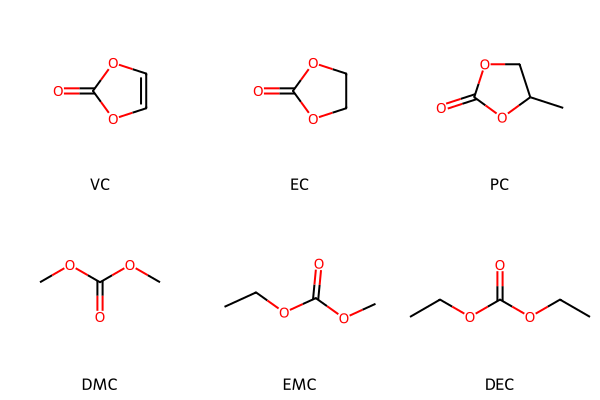

In [17]:
from rdkit import Chem
from rdkit.Chem import Draw

# SMILES strings for each molecule
sm_dict = {
    'VC': 'c1coc(=O)o1',
    'EC': 'C1COC(=O)O1',
    'PC': 'CC1COC(=O)O1',
    'DMC': 'COC(=O)OC',
    'EMC': 'CCOC(=O)OC',
    'DEC': 'CCOC(=O)OCC'
}

Draw.MolsToGridImage([Chem.MolFromSmiles(sm_dict[mol]) for mol in sm_dict], legends=list(sm_dict.keys()))

For this tutorial, we prepared in advance a collection of atomic configurations - let's understand the data! We start by loading the raw configurations with no `labels` (energy, forces). The atomic `configurations`are stored in the [extxyz](https://wiki.fysik.dtu.dk/ase/ase/io/formatoptions.html#extxyz) format and can be accessed using [ASE](https://wiki.fysik.dtu.dk/ase/index.html) as shown below:

In [9]:
from ase.io import read, write
import numpy as np

db = read('data/solvent_configs.xyz', ':') #read in list of configs

print("Number of configs in database: ", len(db))
print("Number of atoms in each config: ", np.array([len(at) for at in db]))
print("Number of atoms in the smallest config: ", np.min([len(at) for at in db])) #test if database contains isolated atoms
print("Information stored in typical config: ", db[10].info, db[10].arrays)

Number of configs in database:  5000
Number of atoms in each config:  [24 22 25 ... 25 32 40]
Number of atoms in the smallest config:  8
Information stored in typical config:  {} {'numbers': array([6, 8, 6, 8, 6, 1, 1, 8, 1, 1, 6, 8, 8, 8, 6, 6, 6, 1, 1, 6, 1, 1,
       1, 1, 1, 1, 1, 1]), 'positions': array([[ 2.42930269,  5.21925545, -2.44555688],
       [ 1.36888075,  4.36736107, -3.07848001],
       [ 1.0430907 ,  3.33270121, -2.205446  ],
       [ 1.83499873,  3.2705152 , -1.20140588],
       [ 2.83662271,  4.2916441 , -1.29654086],
       [ 3.20092463,  5.52685308, -3.12019396],
       [ 1.98896468,  6.07220507, -2.07261896],
       [ 0.15712669,  2.55914021, -2.58440089],
       [ 3.80655074,  3.73805737, -1.62337792],
       [ 3.03487277,  4.82053137, -0.40139091],
       [-1.35643137, -2.96665978,  1.35700715],
       [-1.21188033, -2.7462728 ,  0.1501831 ],
       [-0.54117233, -3.68505168,  2.08627701],
       [-2.42475724, -2.65949082,  2.02500916],
       [ 0.77742571, -4.

In [4]:
import nglview as nv
from ase.build import molecule

# Create methane and water molecules
at1 = molecule('CH4')
at2 = molecule('H2O')

# Create NGLView widgets for the molecules
view1 = nv.show_ase(at1)
view2 = nv.show_ase(at2)

# Display the molecules side by side
view1._remote_call('setSize', target='Widget', args=['400px', '400px'])
view2._remote_call('setSize', target='Widget', args=['400px', '400px'])

view([at1,at2])

NameError: name 'view' is not defined

In [17]:
import nglview as nv
from ase import Atoms

db = read('data/solvent_configs.xyz', ':10') #read in list of configs
v = nv.NGLWidget()

for frame_index in range(len(db)):
  # Get current frame atoms
  atoms = db[frame_index]

  # Clear previous representation (optional for efficiency)
  v.clear_representations()

  # Add representation based on atom information
  
  v.add_ball_and_stick(elements=atoms.get_chemical_symbols(), positions=atoms.get_positions())

# (Optional) Display the final frame
# v.frame = len(db) - 1
v

NGLWidget()

In [24]:
import nglview as nv
from ase import Atoms

# Load your trajectory
trajectory = read('data/solvent_configs.xyz', ':10')  # Replace with your trajectory loading method

# Create NGLview viewer and initial representation
v = nv.show_asetraj(trajectory)

for frame_index in range(1, len(trajectory)):
  # Update atom positions
  # v.molecular_assembly.coordinates = trajectory[frame_index].get_positions()

  # Update atom information (optional)
  v.update_representation(data={'elements': trajectory[frame_index].get_chemical_symbols()})  

  # Update view (optional)
  # v.update()

# (Optional) Display the final frame
v.frame = len(trajectory) - 1
v

NGLWidget(frame=9, max_frame=9)

In [281]:
from ase.io import write

db = read('data/solvent_configs.xyz', '10') #read in list of configs
write('test.pdb', db)

In [278]:
db[0].arrays

{'numbers': array([6, 6, 8, 6, 8, 8, 1, 1, 6, 6, 8, 6, 8, 8, 1, 1, 6, 6, 8, 6, 8, 8,
        1, 1]),
 'positions': array([[ 0.45285612,  3.01426506, -2.32330513],
        [-0.65326887,  3.3203609 , -1.70732403],
        [-0.82637185,  2.63587189, -0.55307001],
        [ 0.26635113,  1.80842292, -0.42423803],
        [ 0.50404215,  1.07012391,  0.477305  ],
        [ 1.20395112,  2.09938192, -1.540591  ],
        [ 0.99488211,  3.42258286, -3.19497991],
        [-1.42996383,  3.95062685, -2.1258359 ],
        [ 1.26803315,  0.08491497,  2.52308202],
        [ 0.71784115, -0.92897701,  3.20788789],
        [ 0.6455251 , -2.02956414,  2.40690088],
        [ 1.62233818, -1.828076  ,  1.46278298],
        [ 2.07954812, -2.65240097,  0.69964898],
        [ 1.90033615, -0.53814703,  1.52785194],
        [ 1.60973608,  0.97362196,  3.01618791],
        [-0.23638988, -0.89091206,  3.98334789],
        [-2.61711597, -1.50253499,  0.01472599],
        [-1.65134692, -2.33284712, -0.232002  ],
    

**Questions:**
1. How many configurations in total?
2. 

At this point each configuration is a collection of atoms: Z number and positions, with no additional information. Let's identify the molecules and label molecular clusters. This will make it easier to inspect the data set and, later, test the accuracy of the potential on describing inter-molecular interactions.
The code takes about `4 min` to run, you can avoid this by commenting out the code block which identifies molecules and simply loading the processed data.

In [20]:
from aseMolec import anaAtoms as aa

aa.wrap_molecs(db[:100], prog=False) #identify molecules and label molecular clusters, first 100 frames
print("Information stored in typical config: ", db[10].info, db[10].arrays) #check the information

Information stored in typical config:  {'Nmols': 2, 'Comp': 'DEC(1):EC(1)'} {'numbers': array([6, 8, 6, 8, 6, 1, 1, 8, 1, 1, 6, 8, 8, 8, 6, 6, 6, 1, 1, 6, 1, 1,
       1, 1, 1, 1, 1, 1]), 'positions': array([[ 2.42930269,  5.21925545, -2.44555688],
       [ 1.36888075,  4.36736107, -3.07848001],
       [ 1.0430907 ,  3.33270121, -2.205446  ],
       [ 1.83499873,  3.2705152 , -1.20140588],
       [ 2.83662271,  4.2916441 , -1.29654086],
       [ 3.20092463,  5.52685308, -3.12019396],
       [ 1.98896468,  6.07220507, -2.07261896],
       [ 0.15712669,  2.55914021, -2.58440089],
       [ 3.80655074,  3.73805737, -1.62337792],
       [ 3.03487277,  4.82053137, -0.40139091],
       [-1.35643137, -2.96665978,  1.35700715],
       [-1.21188033, -2.7462728 ,  0.1501831 ],
       [-0.54117233, -3.68505168,  2.08627701],
       [-2.42475724, -2.65949082,  2.02500916],
       [ 0.77742571, -4.09808683,  1.66831815],
       [-3.53945827, -1.88707876,  1.42200315],
       [ 1.73322475, -4.5084729

This procedure created new information for each atomic config: number of molecules `Nmols`, molecular composition `Comp` (e.g `DEC(1):EC(1)` means the config comprises a dimer with 1 DEC molecule and 1 EC molecule) and molecular ID `molID`.

There are 5000 configs in total, let us inspect what is the distribution of configs by number of molecules present:

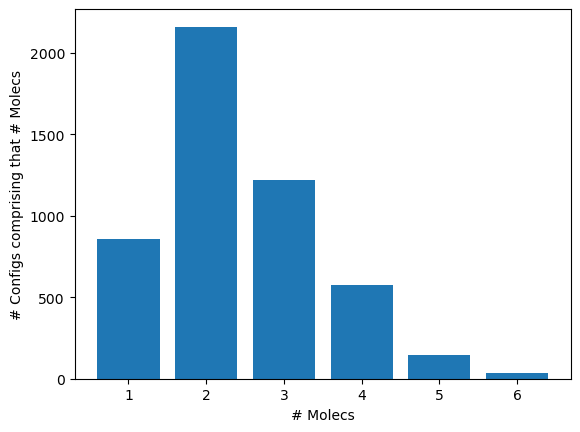

In [15]:
from matplotlib import pyplot as plt

db = read('data/solvent_molecs.xyz', ':')
Nmols = np.array([at.info['Nmols'] for at in db]) #collect Nmols information across all data
plt.hist(Nmols, align='left', bins=[1,2,3,4,5,6,7], rwidth=0.8);
plt.xlabel('# Molecs');
plt.ylabel('# Configs comprising that # Molecs');

There are just under 1000 configs of single molecules and more than 2000 dimers. The largest configs contain clusters of six molecules.

We can check the distribution of molecular compositions for each cluster size:

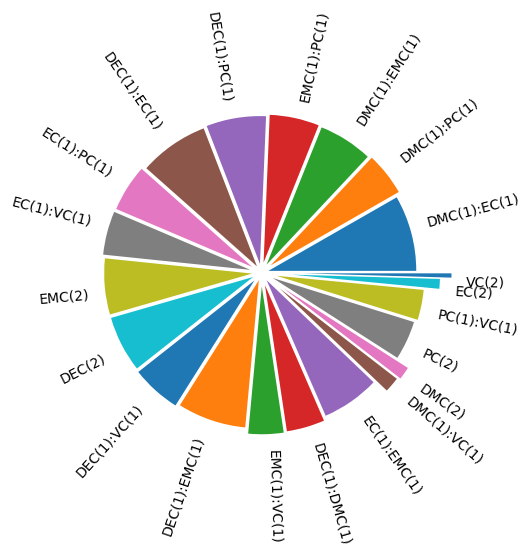

In [16]:
from aseMolec import extAtoms as ea
from collections import Counter

comp_dict = {} #create a dictionary of compositions for each cluster size
for Nmol in range(1,7):
    comp_dict[Nmol] = dict(Counter([at.info['Comp'] for at in ea.sel_by_info_val(db, 'Nmols', Nmol)]))

Nmol = 2 #show distribution of compositions for cluster size 6

plt.pie(comp_dict[Nmol].values(), labels=comp_dict[Nmol].keys(),
        explode=10/(25+np.array(list(comp_dict[Nmol].values()))), rotatelabels =True);


The training set is quite diverse and it contains a good mix of compositions. Check the distribution for other cluster sizes: `Nmol = 1, 2, 3, 4, 5`. Find out if all isolated molecules are present and well sampled. We have six molecules, so there should be 6x6 dimers present, are all dimers sampled?

# Labeling Data with XTB Values

We convinced ourselves the training set is quite diverse, it samples many compositions and molecular cluster sizes. It is time to prepare the reference data (energies, forces) to learn from. We will do this using the Semiempirical Tight Binding level of theory with [XTB](https://xtb-docs.readthedocs.io/en/latest/contents.html). This may be less accurate than other methods specialized for these systems, but it is fast and it will later allow us to test MLIP errors on-the-fly.

Notice the data set contains isolated molecules but no isolated atoms. GAP (and MLIPs in general) fits to atomization energies (eV), so we need to provide the energy of each atom species in vacuum for reference. Let us add three frames containing Hydrogen H, Carbon C and Oxygen O.

In [6]:
from ase import Atoms

db = read('data/solvent_molecs.xyz', ':')
db = [Atoms('H'), Atoms('C'), Atoms('O')]+db #add isolated atoms to the database

for at in db[:3]:
    at.info['config_type'] = 'IsolatedAtom' #useful for tomorrow, MACE requires this tag to find isolated atoms
    at.cell = [20,20,20] #the data is non periodic, but GAP requires a dummy cell to find the isolated atoms

print("Number of configs in database: ", len(db))

Number of configs in database:  5003


Now we compute the energy and forces with XTB. This computation will take about `25 mins` for the 5003 configs. Avoid this by simply loading the already computed data. You can try yourself for a few configs and check that you are getting the same values as the preprocessed data. What is the inherent XTB precision? By how much do values actually differ?

In [13]:
from xtb.ase.calculator import XTB
xtb_calc = XTB(method="GFN2-xTB")
from tqdm import tqdm

ldb = read('data/solvent_xtb.xyz', ':')

for at, lat in tqdm(zip(db, ldb)):
    at.calc = xtb_calc
    at.info['ref_energy'] = at.get_potential_energy()
    at.arrays['red_forces'] = at.get_forces()
    print(at.info['ref_energy'], lat.info['ref_energy'])
    at.calc = None
# write('data/solvent_xtb.xyz', db)

# db = read('data/solvent_xtb.xyz', ':')
# print("Information stored in typical config: ", db[100].info, db[100].arrays) #check the information

0it [00:00, ?it/s]

-10.707211383396714 -10.707211383396714


2it [00:04,  2.50s/it]

-48.847445262804705 -48.847445262804705
-102.57117256025786 -102.57117256025786


4it [00:08,  2.15s/it]

-1602.093208085045 -1602.093208085042


5it [00:11,  2.40s/it]

-1151.6688033579833 -1151.6688033579703


6it [00:15,  2.71s/it]

-1237.2372094893271 -1237.237209489243


7it [00:18,  2.76s/it]

-1265.1800280348236 -1265.180028034832


8it [00:21,  3.07s/it]

-2248.1644835302045 -2248.1644835301763


9it [00:24,  2.98s/it]

-1687.2692238457407 -1687.2692238458048


9it [00:28,  3.14s/it]


KeyboardInterrupt: 

The data now contains one energy value for each config `energy` and the `force` on each atom.
We also have isolated atom energies so we can check atomization energies per atom. This is not a prerequisite for GAP fitting, since GAP will do this internally. It is simply a sanity check:

In [ ]:
ea.get_prop(db, 'bind', peratom=True) #computes atomization energy devided by number of atoms:

Good! We get about -6 $\rm eV/atom$ which is roughly the expected covalent energy for these organic molecules. Remember most of the energy is stored in the covalent bonds.

# Fitting a Simple MACE Model

We will start by splitting the data into train and test sets the same as we did for GAP. In practice MACE extrapolates better than GAP, so we can get away with less data.

In [ ]:
from ase.io import read, write

db = read('data/solvent_xtb.xyz', ':')

#non-periodic data is handled correctly by MACE, so we do not need to change anything
write('data/solvent_mace_train.xyz', db[:203])
write('data/solvent_mace_test.xyz', db[203:403])

#### Training files

To train a MACE model, you will use the `run_train.py`command which takes the following arguments:

First specify the name of your model and final log file using the `--name` flag.

You can specify the training file with the `--train_file` flag. The validation set can either be specified as a separate file using the `--valid_file` keyword, or it can be specified as a fraction of the training set using the `--valid_fraction` keyword. The validation set is not used for optimizing the model but to estimate the model accuracy during training.

It is also possible to provide a test set using the `--test_file` keyword. This set is entirely independent and only gets evaluated at the end of the training process.

__________________

#### Reference energies

It is usually preferred to add the isolated atoms to the training set, rather than reading in their energies through the command line. MACE will automatically identify these atoms in the training set if they are labels correctly with `config_type=IsolatedAtom` in their `info` fields (we have done this yesterday when preparing the data). If you prefer not to use or do not know the energies of the isolated atoms, you can use the option `--E0s="average"` which estimates the atomic energies by least squares regression.

__________________


#### Model

##### The Messages

To control the model size, you need to change `--hidden_irreps`. For most applications, the recommended default model size is `--hidden_irreps='256x0e'` (meaning 256 invariant messages) or `--hidden_irreps='128x0e + 128x1o'` (meaning 128 equivariant messages). If the model is not accurate enough, you can include higher order features, e.g., `128x0e + 128x1o + 128x2e`, or increase the number of channels to `256`. The number of message passing layers can be controled via the `--num_ineractions` parameter. **Increasing the model size and the number of layers will lead to more accurate but slower models.**

##### Correlation order

MACE uses a body order expansion on the site energy:

$$
E_{i} = E^{(0)}_{i} + \sum_{j} E_{ij}^{(1)} + \sum_{jk} E_{ijk}^{(2)} + ...
$$

The correlation order corresponds to the order that MACE induces at each layer. Choosing `--correlation=3` will create basis function of up to 4-body (ijke) indices, for each layer. Because of the multiple layers of MACE, the total correlation order is much higher. A two layers mace, with `--correlation=3` has a total body order of 13.

##### Angular resolution

The angular resolution describes how precise the model can identify angles. This is controled by `l_max`. The higher this integer, more precise is the angular resolution. Larger value will result in more accurate but slower models. The default is `l_max=3`.

##### Cutoff radius

The cutoff radius controls the locality of the model. A `--r_max=3.0` means that the model assumes atoms seperated by a distance of more than 3.0 A do not directly `communicate`. Because the model has two layers, atoms further than 3.0 A can still `communicate` by proxy. The actual receptive field of the model is the number of layers times the cutoff distance.

__________________


#### Data keys

When parsing the data files the energies are read using the keyword `energy` and the forces using the keyword `forces`. To change that, specify the `--energy_key` and `--forces_key`.

__________________


#### Checkpoints

Fitting this model will take about `12 mins`. You can continue the fitting from the last checkpoint by using the flag `--restart_latest`. The checkpoint saves the best model that currently has been trained. All checkpoints are saved in ./checkpoints folder. We can also continue from a restart when extending the dataset.

__________________


#### Training parameters

These parameters are related to the training protocols: `--batch_size` represents the number of configs used to compute the gradients for each full update of all network parameters (stocastic gradient descent). The first `epoch` is completed when all the training data has been employed once in updating the weights and `--epochs` represents the number of such epochs. During training you will notice energy errors are at first much higher than force errors, MACE implements a special protocol that increases the weight on the energy in the loss function (`--swa_energy_weight`) once the forces are sufficiently accurate. The starting epoch for this special protocol can be controled by chaning `--start_swa`.

#### Validation parameters

The validation set controls the stopping of the training. At each `--eval_interval` the model is tested on the validation set. We also evaluate the set by batch size, controlled by `--valid_batch_size`. If the accuracy of the model stops improving on the validation set for `--patience` number of epochs. This is called **early stopping**.


In [ ]:
!python3 ./mace/scripts/run_train.py \
    --name="model" \
    --train_file="data/solvent_mace_train.xyz" \
    --valid_fraction=0.05 \
    --test_file="maceTests/solvent_test.xyz" \
    --E0s="isolated" \
    --energy_key="energy" \
    --forces_key="forces" \
    --model="MACE" \
    --num_interactions=2 \
    --max_ell=2 \
    --hidden_irreps="16x0e" \
    --num_cutoff_basis=5 \
    --correlation=2 \
    --r_max=3.0 \
    --batch_size=5 \
    --valid_batch_size=5 \
    --eval_interval=1 \
    --max_num_epochs=50 \
    --start_swa=15 \
    --swa_energy_weight=1000 \
    --ema \
    --ema_decay=0.99 \
    --amsgrad \
    --error_table="PerAtomRMSE" \
    --default_dtype="float32" \
    --swa \
    --device=cuda \
    --seed=1234

# Testing MACE vs XTB

We will now evaluate the trained model on the test datasets. For this, we can use the eval_configs.py code. One needs to specify the file to evaluate in `--configs`. The path to the model is in `--model`. The `--output` specifies to path of the output file where the predicted energies and forces of MACE are stored. The `--default_dtype="float32"`needs to match the one you used for training.

In [ ]:
#evaluate the train set

!python3 ./mace/scripts/eval_configs.py \
    --configs="data/solvent_mace_train.xyz" \
    --model="model_swa.model" \
    --output="maceTests/solvent_train.xyz" \
    --default_dtype="float32" \
    --info_prefix=""

#evaluate the test set
!python3 ./mace/scripts/eval_configs.py \
    --configs="data/solvent_mace_test.xyz" \
    --model="model_swa.model" \
    --output="maceTests/solvent_test.xyz" \
    --default_dtype="float32" \
    --info_prefix=""

#evaluate the volume scan
!python3 ./mace/scripts/eval_configs.py \
    --configs="data/volumeScan.xyz" \
    --model="model_swa.model" \
    --output="maceTests/volumeScan.xyz" \
    --default_dtype="float32" \
    --info_prefix=""

We can compare MACE vs XTB accuracy on the train and test sets.

In [ ]:
from aseMolec import pltProps as pp
from ase.io import read
import matplotlib.pyplot as plt
from aseMolec import extAtoms as ea 
import numpy as np

def plot_RMSEs(db1, db2, labs):
    plt.figure(figsize=(8,4), dpi=100)
    plt.subplot(1,2,1)
    pp.plot_prop(ea.get_prop(db1, 'info', 'energy', True).flatten(), \
                 ea.get_prop(db2, 'info', 'energy', True).flatten(), \
                 title=r'Energy $(\rm eV/atom)$ ', labs=labs, rel=True)
    plt.subplot(1,2,2)
    pp.plot_prop(np.concatenate(ea.get_prop(db1, 'arrays', 'forces')).flatten(), \
                 np.concatenate(ea.get_prop(db2, 'arrays', 'forces')).flatten(), \
                 title=r'Forces $\rm (eV/\AA)$ ', labs=labs, rel=True)
    plt.tight_layout()
    return

plot_RMSEs(read('data/solvent_mace_test.xyz', ':'), read('maceTests/solvent_test.xyz', ':'), labs=['XTB', 'MACE'])

We can also check the Intra/Inter splits:

In [ ]:
from aseMolec import pltProps as pp
from aseMolec import anaAtoms as aa

db1 = read('data/solvent_mace_test.xyz', ':')
db2 = read('maceTests/solvent_test.xyz', ':')

aa.extract_molecs(db1, intra_inter=True)
aa.extract_molecs(db2, intra_inter=True)

pp.plot_trans_rot_vib(db1, db2, labs=['XTB', 'MACE'])

#db1 = read('data/solvent_test.xyz', ':')
#aa.extract_molecs(db1, intra_inter=True)
#ea.check_keys(db1[:1])
#db2 = read('gapTests/solvent_test.xyz', ':')
#aa.extract_molecs(db2, intra_inter=True)

#pp.plot_trans_rot_vib(db1, db2, labs=['XTB', 'GAP'])

Again, MACE performs better. However, iner-molecular are still difficult to capture - as we expect.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from aseMolec import extAtoms as ea

def plot_vscan(vsname='volumeScan', vspaths=['data', 'maceTests']):
    for i, vspath in enumerate(vspaths):
        db = read(vspath+'/'+vsname+'.xyz', ':')
        config = np.arange(len(db))
        energy = ea.get_prop(db, 'info', 'energy', peratom=True)
        plt.plot(config, energy, '.-', label=vspath, alpha=0.5)
    plt.xlabel(r'Volume Scan Config')
    plt.ylabel(r'Energy ($\rm eV/atom$)')
    plt.legend()
    plt.title(vsname)
    plt.tight_layout()

plot_vscan()

The `volume scan` is still not perfect, but MACE is smoother! More data will be needed to get this right. 

# Molecular Dynamics with MACE

MD is the ultimate test, let's check MACE stability. We will start by implementing a simple function to run Langevin dynamics. We will initialize the temperature at 300 K and remove all translations and rotations.

In [ ]:
from ase.io import read, write
from ase import units
from ase.md.langevin import Langevin
from ase.md.velocitydistribution import Stationary, ZeroRotation, MaxwellBoltzmannDistribution

import random
import os
import time
import numpy as np
import pylab as pl
from IPython import display

def simpleMD(init_conf, temp, calc, fname, s, T):
    init_conf.set_calculator(calc)

    #initialize the temperature
    random.seed(701) #just making sure the MD failure is reproducible
    MaxwellBoltzmannDistribution(init_conf, temperature_K=300) #initialize temperature at 300
    Stationary(init_conf)
    ZeroRotation(init_conf)

    dyn = Langevin(init_conf, 1.0*units.fs, temperature_K=temp, friction=0.1) #drive system to desired temperature

    %matplotlib inline

    time_fs = []
    temperature = []
    energies = []

    #remove previously stored trajectory with the same name
    os.system('rm -rfv '+fname)

    fig, ax = pl.subplots(2, 1, figsize=(6,6), sharex='all', gridspec_kw={'hspace': 0, 'wspace': 0})

    def write_frame():
            dyn.atoms.write(fname, append=True)
            time_fs.append(dyn.get_time()/units.fs)
            temperature.append(dyn.atoms.get_temperature())
            energies.append(dyn.atoms.get_potential_energy()/len(dyn.atoms))

            ax[0].plot(np.array(time_fs), np.array(energies), color="b")
            ax[0].set_ylabel('E (eV/atom)')

            # plot the temperature of the system as subplots
            ax[1].plot(np.array(time_fs), temperature, color="r")
            ax[1].set_ylabel('T (K)')
            ax[1].set_xlabel('Time (fs)')

            display.clear_output(wait=True)
            display.display(pl.gcf())
            time.sleep(0.01)

    dyn.attach(write_frame, interval=s)
    t0 = time.time()
    dyn.run(T)
    t1 = time.time()
    print("MD finished in {0:.2f} minutes!".format((t1-t0)/60))

## Compare MACE and XTB Dynamics

Now we can run MD with MACE. Let's try 2 picoseoncds starting from a single molecule config:

In [ ]:
 #let us start with a single molecule
init_conf = ea.sel_by_info_val(read('data/solvent_molecs.xyz',':'), 'Nmols', 1)[0].copy()

#we can use MACE as a calculator in ASE!
from mace.calculators import MACECalculator
mace_calc = MACECalculator(model_paths=['model_swa.model'], device='cuda', default_dtype="float32")


simpleMD(init_conf, temp=1200, calc=mace_calc, fname='mace_md.xyz', s=10, T=2000)


For reference, we can also run XTB dynamics from the same starting configuration.

In [ ]:
# reinitialize the original config
init_conf = ea.sel_by_info_val(read('data/solvent_molecs.xyz',':'), 'Nmols', 1)[0].copy()

from xtb.ase.calculator import XTB
xtb_calc = XTB(method="GFN2-xTB")

simpleMD(init_conf, temp=1200, calc=xtb_calc, fname='xtb_md.xyz', s=10, T=2000)

Great the dynamics are pretty stable! Download the trajectory files `.xyz` and visualize them with your favourite software.

Are the different dynamics sampling the correct distributions? Let us check the radial distribution functions (RDF). The [aseMolec](https://github.com/imagdau/aseMolec) package provides functionality to do that:

In [ ]:
from aseMolec import anaAtoms as aa

tag = 'HO_intra' #choose one of 'HH_intra', 'HC_intra', 'HO_intra', 'CC_intra', 'CO_intra', 'OO_intra'

for f in ['xtb_md', 'mace_md']:
    traj = read(f+'.xyz', ':')
    for at in traj:
        at.pbc = True
        at.cell = [100,100,100]
    rdf = aa.compute_rdfs_traj_avg(traj, rmax=5, nbins=50) #aseMolec provides functionality to compute RDFs
    plt.plot(rdf[1], rdf[0][tag], label=f, alpha=0.7, linewidth=3)

plt.legend();
plt.yticks([]);
plt.xlabel(r'R ($\rm \AA$)');
plt.ylabel('RDF '+tag);

Try it yourself! Look at other RDF types, how well are they reproduced? The MACE model performes better than GAP.

The trajectories here are pretty stable, but this is a pretty simple problem. We chose a single molecule at relatively small temperatures (for a molecule) and only ran for 2 picoseconds. In practice, given enough time and high enough temperature the initial models will fail.

Experiment with the starting configs, temperatures, simulation length, see if you can find problems with the potentials!

## The Molecular Liquid Condensed Phase

The MLIP was trained on clusters, can we simulate the liquid molecular environment?

In [ ]:
init_conf = read('data/ECEMC.xyz','4') #read a liquid config with periodic boundary conditions
init_conf.center()

simpleMD(init_conf, temp=500, calc=mace_calc, fname='liquid_md.xyz', s=10, T=2000)

This XTB calculator is non-periodic, so this dynamics would not be possible without an MLIP! Check for yourself, by replacing the calculator with xtb. The system is much larger than the example before (12 molecules vs just one), check how GAP scales with size by replacing the calculator with gap.


Transferability from clusters to the condensed phase environment is still an open research question. If this works, it implies that we might be able to learn on highly accuracte Quantum Chemistry methods on molecular clusters and make predictions (density, diffusivity) for the condensed phase! This is new Science!